# Project Assignment 3
### Roger A. Leyba 
### GGIS 407
### Prof. Admanabhan

##### The project I am pursuing on CyberGISX is about relating Air Quality in Illinois to land use and socioeconomic factors. My hypothesis is that air quality has a relationship with socioeconomic factors such as population density and socioeconomic status and land use facors such as urbanization. 

##### The data sources I would be using for the project are Illinois State Geological Survey Clearinghouse, EPA, U.S. Census Bureau, and Illinois State Geological Survey Clearinghouse for the data regarding county boundaries, air quality index, population density, and land use/land cover respectively. 

##### As for the scenarios I hope to achieve is to map state-wide air quality interpolated data (1), population density (2), and land use/land cover (3). 

In [131]:
%matplotlib inline
import os
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import IPython
import zipfile
import rasterio
from rasterio.io import MemoryFile
import shapely
import warnings
import numpy as np
import shapely
import shapely.geometry
from shapely.geometry import Point
from shapely.geometry import box
from shapely.errors import ShapelyDeprecationWarning
from scipy.interpolate import griddata

In [133]:
# Path to the uploaded zip file
zip_file_path = "/home/jovyan/work/Project/IL_BNDY_County.zip"

# Extract the shapefile
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract all contents to a temporary directory
    zip_ref.extractall("temp_dir")

# List all files in the temporary directory
extracted_files = os.listdir("temp_dir")

# Assuming the shapefile is the only one of interest, find its path
shp_file_path = [f for f in extracted_files if f.endswith('.shp')][0]

# Read the shapefile using GeoPandas
illinois = gpd.read_file(os.path.join("temp_dir", shp_file_path))
population =  pd.read_csv('Illinois Population Data.csv')

In [ ]:
# Plot Illinois map by counties
ax = illinois.plot(color='orange')
ax.set_title('Illinois State By Counties')
ax

In [57]:
# Read and preview AQI data to be used
point_data = pd.read_csv('PM_AQI_2022_IL.csv')
point_data.head()

,PM_YEARLY,AQI_YEARLY,SITE_NAME,SITE_LATITUDE,SITE_LONGITUDE
0,7.410924,30.411765,904 North Walnut,40.123886,-88.240553
1,8.740401,35.295129,AGRICULTURE BUILDING,39.831921,-89.644164
2,8.846018,35.274336,ALTON HORACE MANN ELEMENTARY SCHOOL,38.901362,-90.146308
3,9.044571,36.177143,CARY GROVE HS,42.221442,-88.242207
4,9.266849,37.010959,CITY HALL,41.771071,-88.152534


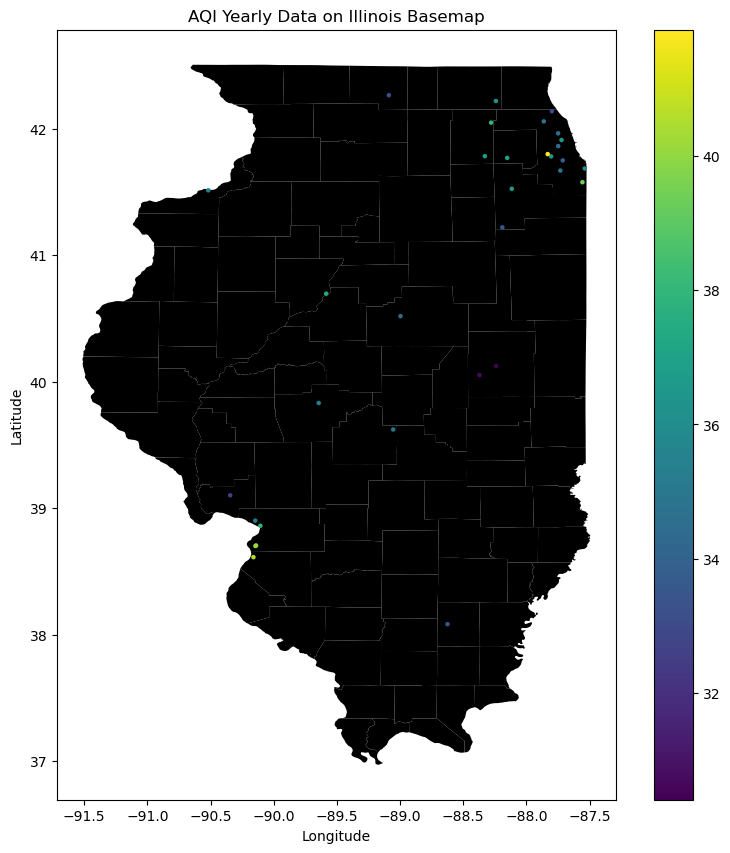

In [127]:
# Plot AQI data

# Suppress Shapely deprecation warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=ShapelyDeprecationWarning)
    
    # Convert latitude and longitude to Shapely Point objects
    points = point_data.apply(lambda row: Point(row['SITE_LONGITUDE'], row['SITE_LATITUDE']), axis=1)

# Add the points as a new column in the GeoDataFrame
point_data['geometry'] = points

# Convert to GeoDataFrame
gdf_points = gpd.GeoDataFrame(point_data, geometry='geometry')

# Plot the shapefile
fig, ax = plt.subplots(figsize=(10, 10))
illinois.plot(ax=ax, color='black')

# Plot AQI data on top of the shapefile
gdf_points.plot(ax=ax, column='AQI_YEARLY', cmap='viridis', markersize=5, legend=True)

plt.title('AQI Yearly Data on Illinois Basemap')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [12]:
# Extract columns
xi = point_data['SITE_LONGITUDE']
yi = point_data['SITE_LATITUDE']
zi = point_data['AQI_YEARLY']

In [16]:
# Create a grid based on the bounding box of the shapefile
x = np.linspace(illinois.bounds.minx.min(), illinois.bounds.maxx.max(), 100)
y = np.linspace(illinois.bounds.miny.min(), illinois.bounds.maxy.max(), 100)
X, Y = np.meshgrid(x, y)

In [17]:
# Interpolate using griddata
Z = griddata((xi, yi), zi, (X, Y), method='linear')

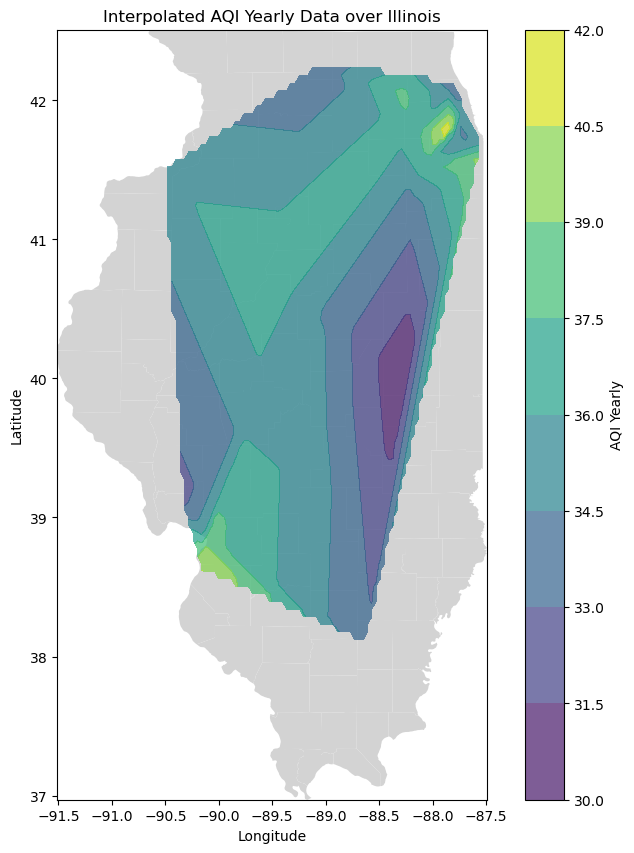

In [74]:
fig, ax = plt.subplots(figsize=(10, 10))
illinois.plot(ax=ax, color='lightgrey')
im = ax.contourf(X, Y, Z, cmap='viridis', alpha=0.7)
plt.colorbar(im, ax=ax, label='AQI Yearly')
plt.title('Interpolated AQI Yearly Data over Illinois')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [44]:
# Convert interpolated grid to DataFrame
df_interpolated = pd.DataFrame({'Longitude': X.flatten(), 'Latitude': Y.flatten(), 'Interpolated_AQI': Z.flatten()})
df_interpolated = df_interpolated.dropna()

# Display the first few rows of the DataFrame
df_interpolated

,Longitude,Latitude,Interpolated_AQI
2212,-88.728555,38.121515,33.866891
2213,-88.688770,38.121515,33.585310
2214,-88.648984,38.121515,33.463077
2310,-88.887696,38.176351,34.612122
2311,-88.847910,38.176351,34.383288
...,...,...,...
9864,-88.648984,42.234171,34.852023
9865,-88.609199,42.234171,34.967999
9866,-88.569414,42.234171,35.083976
9867,-88.529629,42.234171,35.199953


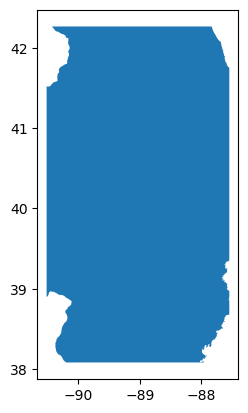

In [130]:
#### FAILED ATTEMPT TO DISSOLVE ILLINOIS MAP BASED ON INTERPOLATED DATA BOUNDARIES


# Calculate the minimum and maximum values of X and Y
minx, maxx = np.min(xi), np.max(xi)
miny, maxy = np.min(yi), np.max(yi)

# Create a bounding box geometry
bbox = box(minx, miny, maxx, maxy)

## Calculate the intersection between the shapefile and the bounding box
intersection = illinois.intersection(bbox)

# Create a GeoDataFrame from the intersection
intersection_gdf = gpd.GeoDataFrame(geometry=intersection)

# Dissolve the resulting geometries
dissolved_gdf = intersection_gdf.dissolve()

# Plot the dissolved shapefile
dissolved_gdf.plot()
plt.show()

##### Next I will map the land cover classification daa

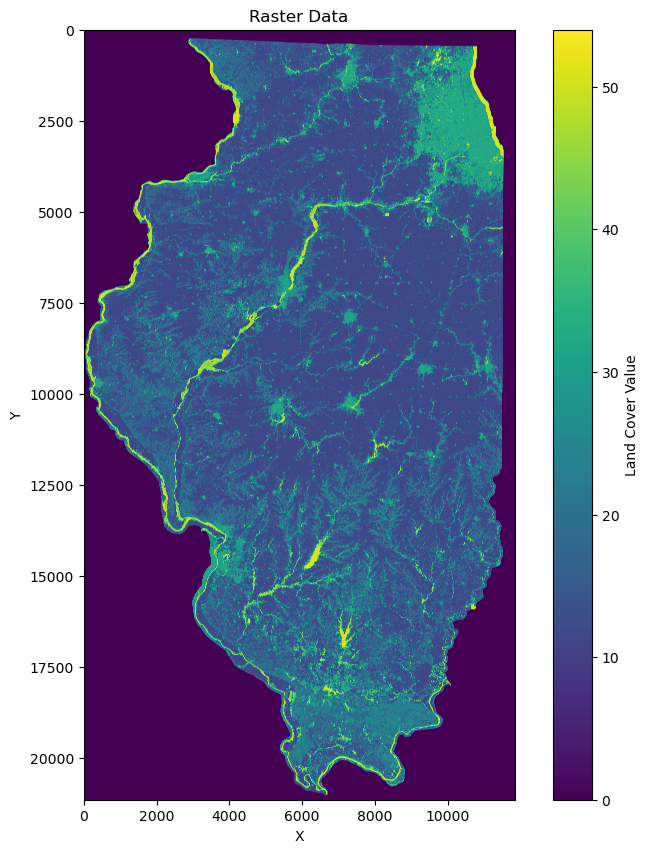

In [95]:
zipped_tiff_path = '/home/jovyan/work/Project/gap_geotiff.zip'

# Extract the TIFF file from the zip archive
with zipfile.ZipFile(zipped_tiff_path, 'r') as zip_ref:
    zip_info = zip_ref.infolist()
    tiff_file = None
    for file_info in zip_info:
        if file_info.filename.endswith('.tif'):
            tiff_file = file_info.filename
            zip_ref.extract(tiff_file, path='temp')
            break

# Open the TIFF file
with rasterio.open('temp/' + tiff_file) as src:
    # Read the raster data
    data = src.read(1)  # assuming it's a single-band raster

    # Plot the raster data
    plt.figure(figsize=(10, 10))
    plt.imshow(data, cmap='viridis')
    plt.colorbar(label='Land Cover Value')
    plt.title('Raster Data')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.show()

In [115]:
# Lowercase the county names in the shapefile
illinois['COUNTY_NAM'] = illinois['COUNTY_NAM'].str.lower()

# Load the population data by county
population_data = pd.read_csv('Illinois Population Data.csv')
population_data.rename(columns={'State/City/County': 'COUNTY_NAM'}, inplace=True)

# Lowercase the county names in the population data table
population_data['COUNTY_NAM'] = population_data['COUNTY_NAM'].str.lower()

# Perform the join based on the lowercase county name
merged_data = illinois.merge(population_data, on='COUNTY_NAM')

# Display the merged data
print(merged_data.head())

  COUNTY_NAM  CO_FIPS                                           geometry   
0    mchenry      111  POLYGON ((-88.70742 42.49351, -88.68809 42.493...  \
1      boone        7  POLYGON ((-88.70742 42.49351, -88.70740 42.493...   
2       ogle      141  POLYGON ((-89.68808 42.19949, -89.66846 42.200...   
3       will      197  POLYGON ((-88.26146 41.72439, -88.26146 41.724...   
4    lasalle       99  POLYGON ((-88.93885 41.62836, -88.93871 41.628...   

     2020  
0  310229  
1   53448  
2   51788  
3  696355  
4  109658  


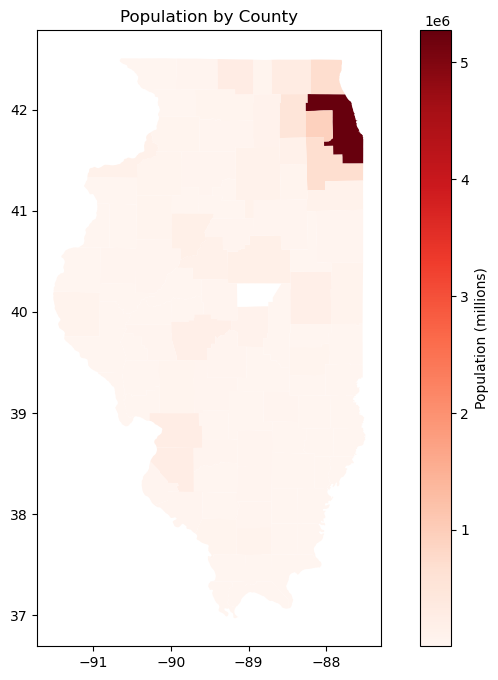

In [129]:
# Plot the merged data
fig, ax = plt.subplots(figsize=(10, 8))
merged_data.plot(ax=ax, column='2020', cmap='Reds', legend=True,
                 legend_kwds={'label': 'Population (millions)'})
ax.set_title('Population by County')
plt.show()